<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from torchvision import transforms

%matplotlib inline

In [2]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...


--2024-05-06 06:51:26--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: 'tmp.tgz'

     0K .......... .......... .......... .......... ..........  0%  534K 3m19s
    50K .......... .......... .......... .......... ..........  0%  986K 2m33s
   100K .......... .......... .......... .......... ..........  0%  792K 2m27s
   150K .......... .......... .......... .......... ..........  0%  661K 2m30s
   200K .......... .......... .......... .......... ..........  0%  213M 2m0s
   250K .......... .......... .......... .......... ..........  0% 1.05M 1m56s
   300K .......... .......... .......... .......... ..........  0%  140K 3m28s
   350K .......... .......... .......... .......... ..........  0%  115M 3m2s
   400K ......

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2024-05-06 06:52:29--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2024-05-06 06:52:30--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: 'lfw_attributes.txt'

     0K .......... .......... .......... .......... ..........  0%  847K 17s
    50K .......... .......... .......... .......... ..........  0% 1.65M 13s
   100K .......... .......... .......... .......... ..........  1% 52.1M 9s
   150K .......... .......... .......... 

done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [5]:
def plot_images(images, nrows=3, ncols=3, from_torch=False):
  if from_torch:
    images = [x.data.numpy().transpose(1, 2, 0) for x in images]
  plt.figure(figsize=(1.5 * ncols, 1.5 * nrows))
  plt.subplots_adjust(bottom=0, left= 0.01, right=.99, top=0.9, hspace=.35)

  for i in range(nrows * ncols):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(images[i])
    plt.xticks(())
    plt.yticks(())
  plt.show()

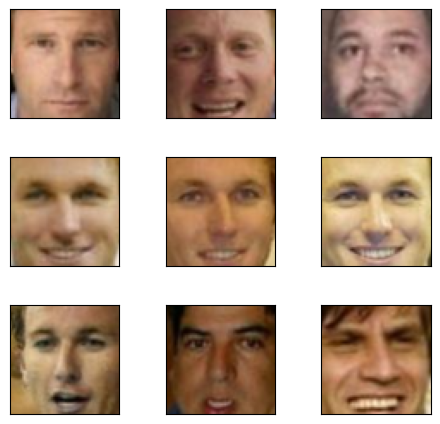

In [6]:
plot_images(data)

In [7]:
np.array(data[0]).shape

(64, 64, 3)

In [8]:
class Faces(Dataset):
  def __init__(self, faces):
    self.data = faces
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  def __getitem__(self, index):
    x = self.transform(self.data[index])
    return x.float()
  def __len__(self):
    return len(self.data)

In [9]:
dataset = Faces(data)

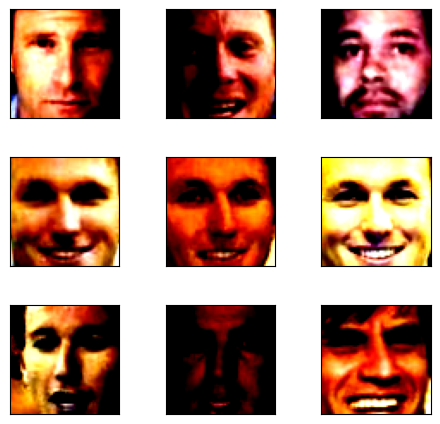

In [10]:
plot_images(dataset, from_torch = True)

In [11]:
dataset[0].shape

torch.Size([3, 64, 64])

In [12]:
len(dataset)

13143

In [13]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

g_cpu = torch.Generator().manual_seed(42)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

In [14]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [15]:
from copy import deepcopy

def encoder_block(in_ch, out_ch, kernel=3, padding=1):
    block = nn.Sequential(
      nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, padding=padding, stride=2),
      nn.BatchNorm2d(out_ch),
      nn.ReLU() 
    )
    return block

def latent_space(in_size, out_size):
    block = nn.Sequential(
      nn.Linear(in_size, out_size)
    )
    return block

def decoder_block(in_ch, out_ch, kernel=2, padding=0):
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, padding=padding, stride=2),
        nn.BatchNorm2d(out_ch),
        nn.ReLU() 
    )
    return block


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
          encoder_block(3, 16),
          encoder_block(16, 32),
          encoder_block(32, 64)
        )

        self.latent = nn.Sequential(
            latent_space(64 * 8 * 8, 64 * 8 * 8)
        )

        self.decoder = nn.Sequential(
          decoder_block(64, 32),
          decoder_block(32, 16),
          decoder_block(16, 16)
        )
        self.out = nn.Sequential(
            nn.Conv2d(16, 3, kernel_size=1)
        )
    def forward(self, x):
        x = self.encoder(x)
        shape = x.shape
        x_flattened = x.view(x.size(0), -1)
        latent = self.latent(x_flattened)
        x_deflattened = latent.view(shape[0], shape[1], shape[2], shape[3])
        pre_reconstruction = self.decoder(x_deflattened)
        reconstruction = self.out(pre_reconstruction)
        return reconstruction, latent

    def decode(self, x):
        reconstruction = self.out(self.decoder(x))
        return reconstruction

# ниже закоментированный вариант с макспуллингом - работает хуже

In [16]:
'''
from copy import deepcopy

def encoder_block(in_ch, out_ch, kernel=3, padding=1):
  block = nn.Sequential(
      nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, padding=padding),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
  )
  return block

def latent_space(in_size, out_size):
  block = nn.Sequential(
      nn.Linear(in_size, out_size)
  )
  return block

def decoder_block(in_ch, out_ch, kernel=3, padding=1):
  block = nn.Sequential(
      nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, padding=padding),
      nn.BatchNorm2d(out_ch),
      nn.ReLU(),
      nn.Upsample(scale_factor=2, mode='bilinear')
  )
  return block


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
          encoder_block(3, 16),
          encoder_block(16, 32),
          encoder_block(32, 64)
        )

        self.latent = nn.Sequential(
            latent_space(64 * 8 * 8, 64 * 8 * 8)
        )

        self.decoder = nn.Sequential(
          decoder_block(64, 32),
          decoder_block(32, 16),
          decoder_block(16, 16)
        )
        self.out = nn.Sequential(
            nn.Conv2d(16, 3, kernel_size=1)
        )
    def forward(self, x):
      x = self.encoder(x)
      shape = x.shape
      x_flattened = x.view(x.size(0), -1)
      latent = self.latent(x_flattened)
      x_deflattened = latent.view(shape[0], shape[1], shape[2], shape[3])
      pre_reconstruction = self.decoder(x_deflattened)
      reconstruction = self.out(pre_reconstruction)
      return reconstruction, latent

    def decode(self, x):
      reconstruction = self.out(self.decoder(x))
      return reconstruction
'''

"\nfrom copy import deepcopy\n\ndef encoder_block(in_ch, out_ch, kernel=3, padding=1):\n  block = nn.Sequential(\n      nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, padding=padding),\n      nn.BatchNorm2d(out_ch),\n      nn.ReLU(),\n      nn.MaxPool2d(kernel_size=2)\n  )\n  return block\n\ndef latent_space(in_size, out_size):\n  block = nn.Sequential(\n      nn.Linear(in_size, out_size)\n  )\n  return block\n\ndef decoder_block(in_ch, out_ch, kernel=3, padding=1):\n  block = nn.Sequential(\n      nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, padding=padding),\n      nn.BatchNorm2d(out_ch),\n      nn.ReLU(),\n      nn.Upsample(scale_factor=2, mode='bilinear')\n  )\n  return block\n\n\nclass Autoencoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        self.encoder = nn.Sequential(\n          encoder_block(3, 16),\n          encoder_block(16, 32),\n          encoder_block(32, 64)\n        )\n\n        self.latent 

In [17]:
def denorm(image):
  stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
  return image * stats[1][0] + stats[0][0]

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [18]:
from IPython.display import clear_output

def train(model, train_loader, val_loader, n_epochs, optimizer, loss_fn, bce=False):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        print('* Epoch %d/%d' % (epoch+1, n_epochs))
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstruction, _ = model(batch)
            if bce:
                batch = torch.sigmoid(batch)
                reconstruction = torch.sigmoid(reconstruction)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                reconstruction, _ = model(batch)
                if bce:
                    batch = torch.sigmoid(batch)
                    reconstruction = torch.sigmoid(reconstruction)
                loss = criterion(reconstruction, batch)
                val_loss += loss.item()
        val_losses.append(val_loss/len(train_loader))

        #Vizualization:
        x_val = next(iter(val_loader))
        prediction, _ = model(x_val.to(device))
        y_hat = prediction.detach().cpu().numpy()
        y_hat = np.argmax(y_hat, axis=1)

        clear_output(wait=True)

        _, axes = plt.subplots(2, 6, figsize=(6*4, 2*4))
        for k in range(6):
            axes[0][k].imshow(denorm(x_val[k].data.cpu().numpy().transpose(1,2,0)), aspect='auto')
            axes[0][k].title.set_text('Input')

            axes[1][k].imshow(denorm(prediction[k].data.cpu().numpy().transpose(1,2,0)), aspect='auto')
            axes[1][k].title.set_text('Output')
        plt.suptitle(f'Train loss: {round(train_losses[-1], 3)}\nValidation loss: {round(val_losses[-1], 3)}')
        plt.show()
    return train_losses, val_losses


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [20]:
criterion = nn.MSELoss()

autoencoder = Autoencoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [21]:
summary(autoencoder,
        input_size=(16, 3, 64, 64), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Autoencoder (Autoencoder)                [16, 3, 64, 64]      [16, 3, 64, 64]      --                   True
├─Sequential (encoder)                   [16, 3, 64, 64]      [16, 64, 8, 8]       --                   True
│    └─Sequential (0)                    [16, 3, 64, 64]      [16, 16, 32, 32]     --                   True
│    │    └─Conv2d (0)                   [16, 3, 64, 64]      [16, 16, 32, 32]     448                  True
│    │    └─BatchNorm2d (1)              [16, 16, 32, 32]     [16, 16, 32, 32]     32                   True
│    │    └─ReLU (2)                     [16, 16, 32, 32]     [16, 16, 32, 32]     --                   --
│    └─Sequential (1)                    [16, 16, 32, 32]     [16, 32, 16, 16]     --                   True
│    │    └─Conv2d (0)                   [16, 16, 32, 32]     [16, 32, 16, 16]     4,640                True
│    │    └─Batc

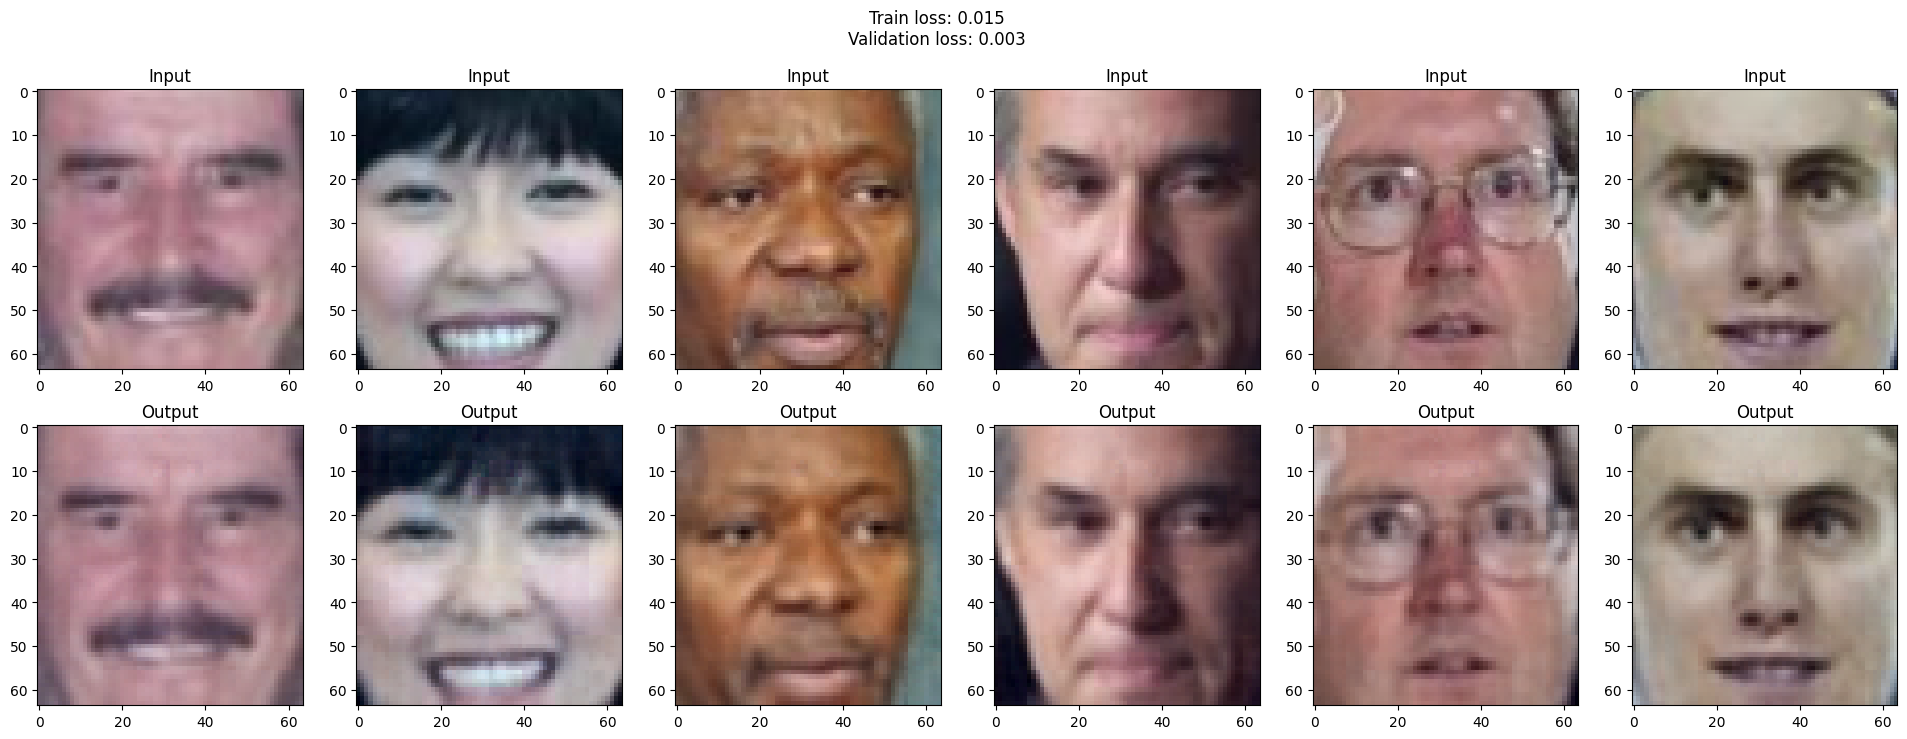

In [28]:
tr_losses, val_losses = train(autoencoder.to(device), train_loader, val_loader, 15, optimizer, criterion)

# попробуем с BCE loss

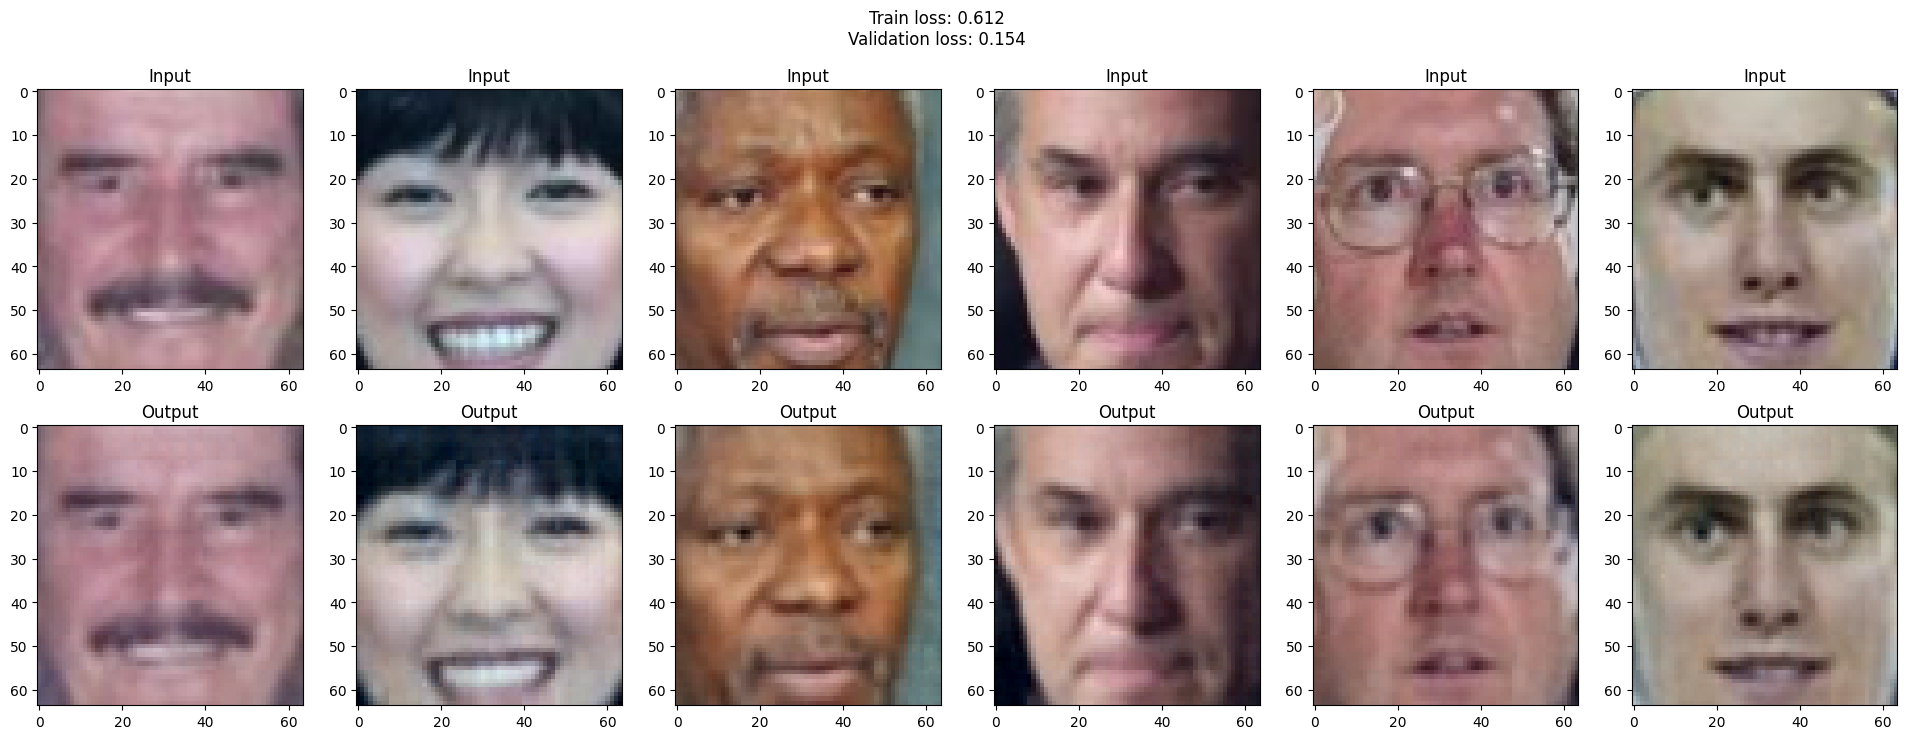

In [29]:
criterion = nn.BCELoss()

autoencoder_bce = Autoencoder()

optimizer = torch.optim.Adam(autoencoder_bce.parameters(), lr=0.001)

tr_losses_bce, val_losses_bce = train(autoencoder_bce.to(device), train_loader, val_loader, 15, optimizer, criterion, bce = True)

In [69]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses, ylim=(0,1)):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(ylim)

    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [44]:
torch.save(autoencoder.state_dict(), 'model_weights_AE.pth')

In [31]:
#autoencoder.load_state_dict(torch.load('/kaggle/working/model_weights_AE.pth'))

<All keys matched successfully>

In [45]:
from IPython.display import FileLink
FileLink(r'model_weights_AE.pth')

/kaggle/working/model_weights_AE.pth

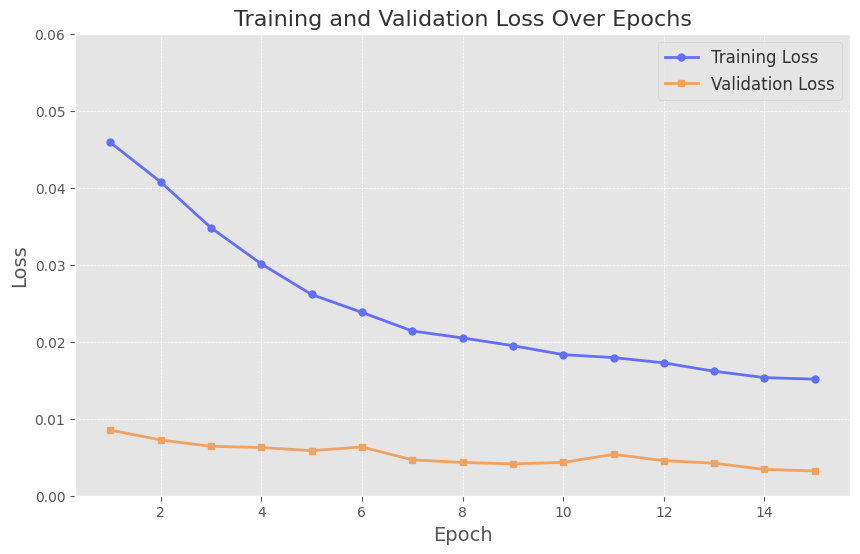

In [31]:
plot_learning_curves(tr_losses, val_losses, (0, 0.06))

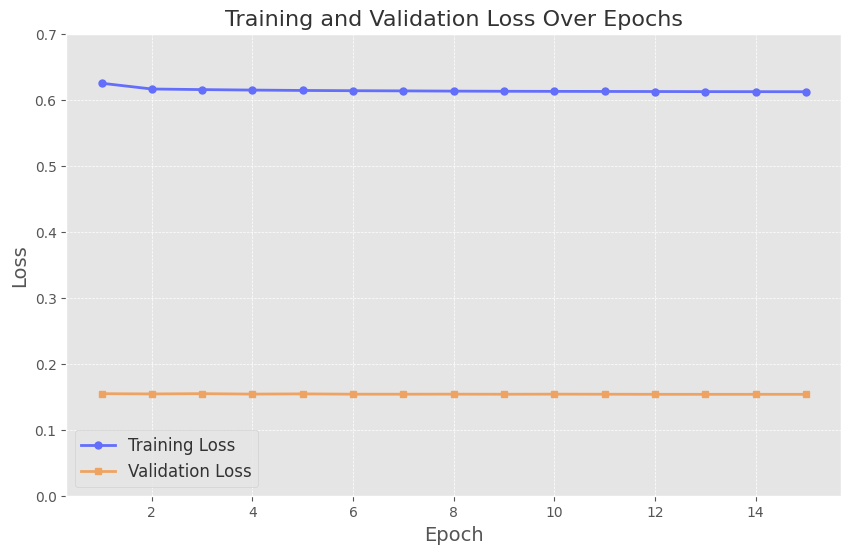

In [35]:
plot_learning_curves(tr_losses_bce, val_losses_bce, (0, 0.7))

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [52]:
def print_16(data):
    ctr = 0
    _, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for k in range(4):
            axes[i][k].imshow(denorm(data[ctr].data.cpu().numpy().transpose(1,2,0)), aspect='auto')
            axes[i][k].axis('off')  # Убираем оси
            axes[i][k].set_xticks([])  # Убираем деления на оси X
            axes[i][k].set_yticks([])  # Убираем деления на оси Y
            axes[i][k].set_aspect('auto')  # Устанавливаем соотношение сторон
            ctr += 1

    plt.subplots_adjust(wspace=0, hspace=0)  # Устанавливаем пространство между изображениями
    plt.show()

In [38]:
# сгенерируем 16 рандомных векторов размера latent_space
z = torch.from_numpy(np.random.randn(16, 64, 8, 8)).float()
output = autoencoder.decode(z.to(device))

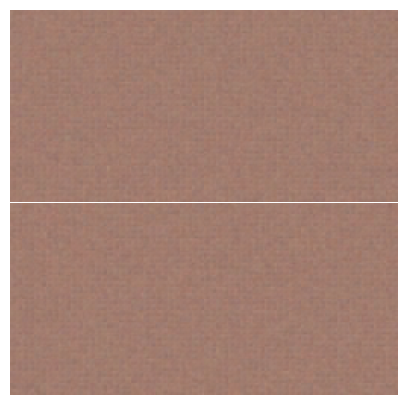

In [39]:
print_16(output)

# получилась неразбериха, так что давайте возьмем 100 картинок, получим 100 латентных векторов и сделаем латентные вектора на основе их параметров

# попробуем сначала  с автоэнкодером который был обучен с MSE loss 

In [54]:
generate_loader = DataLoader(train_data, batch_size=100, shuffle=True)

In [55]:
x = next(iter(generate_loader)).to(device)

In [56]:
_, latent_vector = autoencoder(x.to(device))

In [57]:
latent_vector_numpy = latent_vector.cpu().detach().numpy() # переводим вектора в нумпай
latent_mean = np.mean(latent_vector_numpy, axis=0) # получаем матожидания
latent_covariance = np.cov(latent_vector_numpy, rowvar=False) # матрица ковариации

In [58]:
# генерим 16 случайных латентных векторов
num_samples = 16
random_latent_vectors = np.random.multivariate_normal(latent_mean, latent_covariance, size=num_samples)

In [59]:
# конвертируем обратно в торч
random_latent_vectors_torch = torch.from_numpy(random_latent_vectors).float()

In [60]:
# ресайзим как надо
random_latent_vectors_torch = random_latent_vectors_torch.view(-1, 64, 8, 8)

In [61]:
# Подача случайных векторов декодеру  
decoded_images = autoencoder.decode(random_latent_vectors_torch.to(device))

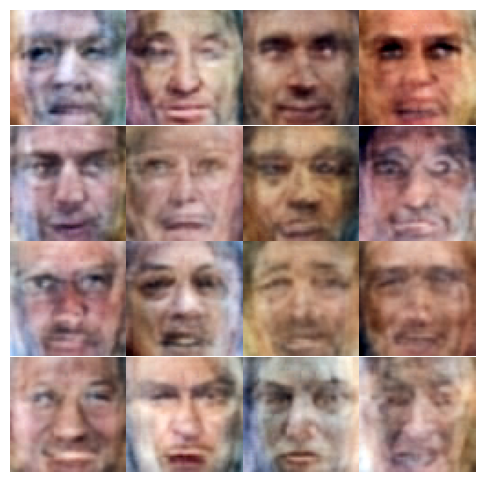

In [62]:
# ву аля, что то да получилось
print_16(decoded_images)

# теперь тоже самое с автоэнкодером выучившимся с BCE loss

In [63]:
_, latent_vector = autoencoder_bce(x.to(device))
latent_vector_numpy = latent_vector.cpu().detach().numpy() # переводим вектора в нумпай
latent_mean = np.mean(latent_vector_numpy, axis=0) # получаем матожидания
latent_covariance = np.cov(latent_vector_numpy, rowvar=False) # матрица ковариации

# генерим 16 случайных латентных векторов
num_samples = 16
random_latent_vectors = np.random.multivariate_normal(latent_mean, latent_covariance, size=num_samples)

# конвертируем обратно в торч
random_latent_vectors_torch = torch.from_numpy(random_latent_vectors).float()
# ресайзим как надо
random_latent_vectors_torch = random_latent_vectors_torch.view(-1, 64, 8, 8)

In [64]:
decoded_images = autoencoder_bce.decode(random_latent_vectors_torch.to(device))

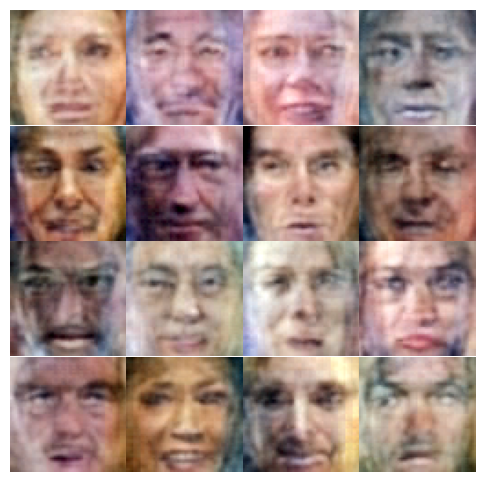

In [65]:
print_16(decoded_images)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [71]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [72]:
smiling_indicies = list(attrs.sort_values(by=['Smiling'], ascending=False).head(16).index)
sad_indicies = list(attrs.sort_values(by=['Smiling'], ascending=True).head(16).index)

In [73]:
smiling_set = [data[i] for i in smiling_indicies]
sad_set = [data[i] for i in sad_indicies]

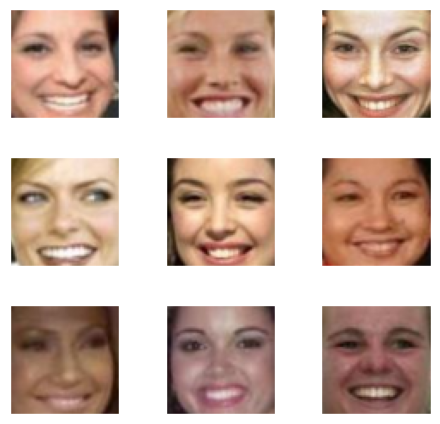

In [74]:
plot_images(smiling_set)

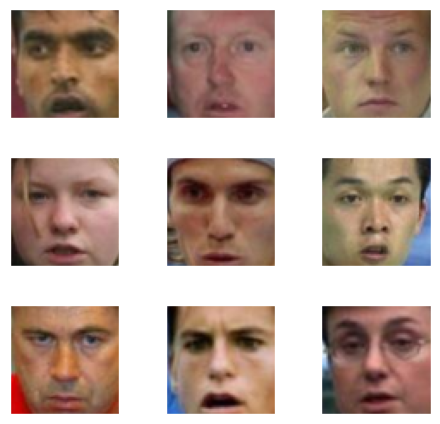

In [75]:
plot_images(sad_set)

In [76]:
smiling_set = Faces(smiling_set)
sad_set = Faces(sad_set)

In [77]:
smile_loader = DataLoader(smiling_set, batch_size=16, shuffle=False)
sad_loader = DataLoader(sad_set, batch_size=16, shuffle=False)

In [78]:
smile_data = next(iter(smile_loader))
sad_data = next(iter(sad_loader))

In [79]:
_, smile_latent = autoencoder(smile_data)
_, sad_latent = autoencoder(sad_data)

In [80]:
mean_smile = torch.mean(smile_latent, dim=0)
mean_sad = torch.mean(sad_latent, dim=0)

In [81]:
different = mean_smile - mean_sad

# Сначала выведем этих грустных людей, потом уже присобачим им улыбки

In [82]:
sad = sad_latent.view(-1, 64, 8, 8)
sad_images = autoencoder.decode(sad)

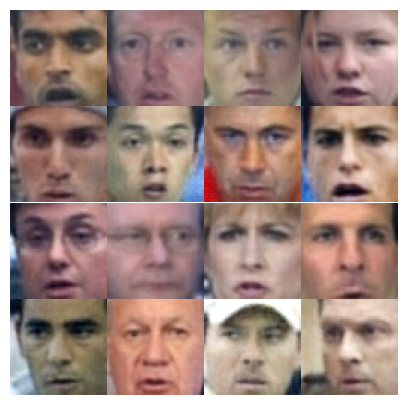

In [83]:
print_16(sad_images)

In [84]:
sad_latent_transformed = sad_latent + different

In [85]:
sad_latent_transformed = sad_latent_transformed.view(-1, 64, 8, 8)
sad_transformed_images = autoencoder.decode(sad_latent_transformed)

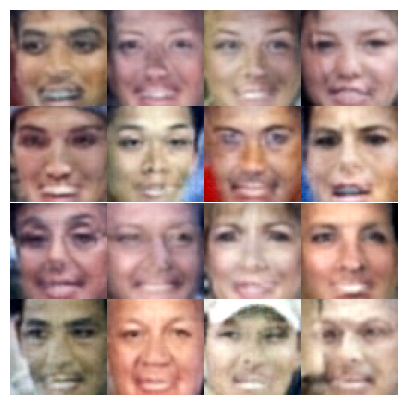

In [86]:
print_16(sad_transformed_images)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 41190334.47it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1051835.56it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8497840.97it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2379531.45it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [60]:
class LinearVAE(nn.Module):
    def __init__(self, train=True, latent_dim=64):
        super().__init__()
        self.training = train
        self.latent_dim = latent_dim
        
        self.encode_block = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dim*2) 
            )
      
        self.flatten = nn.Flatten()
        
        
        self.decode_block = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
            )
         
        
    def encode(self, x): 
        x = self.flatten(x)
        mu, logvar = torch.split(self.encode_block(x), self.latent_dim, dim=-1)   
        return mu, logvar 

    def gaussian_sampler(self, mu, logvar):
        if self.training: 
            eps = torch.randn_like(logvar) # `randn_like` as we need the same size
            std = torch.exp(0.5 * logvar) # standard deviation
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, train=False):
        self.training = train
        reconstruction = self.decode_block(z)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar) 
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction
    
    def get_latent(self, x, train=False):
        self.training = train
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)
        return z

In [29]:
'''
class VAE(nn.Module):
    def __init__(self, in_ch, n_filters, train=True):
        super().__init__()
        self.training = train
        self.in_ch = in_ch
        self.n_filters = n_filters
        
        self.encode_conv_block = nn.Sequential(
            nn.Conv2d(in_channels=self.in_ch, out_channels=self.n_filters, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=self.n_filters, out_channels=self.n_filters*2, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.n_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
      
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(7 * 7 * self.n_filters*2, 7 * 7 * self.n_filters*2)
        
        
        self.decode_conv_block = nn.Sequential(
            nn.Conv2d(in_channels=self.n_filters*2, out_channels=self.n_filters, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.n_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=self.n_filters, out_channels=self.n_filters, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(self.n_filters),
            nn.Upsample(scale_factor=2)
            )
        
        self.out = nn.Sequential(
            nn.Conv2d(self.n_filters, self.in_ch, kernel_size=1),
            nn.Sigmoid()
        )
        
    def encode(self, x): 
        x = self.encode_conv_block(x)
        shape = x.shape
        x = self.flatten(x)
        mu = self.linear(x)
        logsigma = self.linear(x)
        return mu, logsigma, shape

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        x = self.decode_conv_block(z)
        reconstruction = self.out(x)
        return reconstruction

    def forward(self, x):
        mu, logsigma, shape = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        z = z.view(shape[0], shape[1], shape[2], shape[3])
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction
'''

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [61]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def criterion(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [62]:
autoencoder = LinearVAE(latent_dim=128)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [63]:
summary(autoencoder,
        input_size=(32, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LinearVAE (LinearVAE)                    [32, 1, 28, 28]      [32, 128]            --                   True
├─Flatten (flatten)                      [32, 1, 28, 28]      [32, 784]            --                   --
├─Sequential (encode_block)              [32, 784]            [32, 256]            --                   True
│    └─Linear (0)                        [32, 784]            [32, 512]            401,920              True
│    └─ReLU (1)                          [32, 512]            [32, 512]            --                   --
│    └─Linear (2)                        [32, 512]            [32, 256]            131,328              True
│    └─ReLU (3)                          [32, 256]            [32, 256]            --                   --
│    └─Linear (4)                        [32, 256]            [32, 256]            65,792               True
├─Sequential (decode

In [65]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [66]:
from IPython.display import clear_output

def train(model, train_loader, val_loader, n_epochs, optimizer, loss_fn):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        print('* Epoch %d/%d' % (epoch+1, n_epochs))
        model.train()
        train_loss = 0
        for batch, _ in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(batch)
            loss = criterion(batch, mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, _ in val_loader:
                batch = batch.to(device)
                mu, logsigma, reconstruction = model(batch)
                loss = criterion(batch, mu, logsigma, reconstruction)
                val_loss += loss.item()
        val_losses.append(val_loss/len(train_loader))
        print(f'Train loss: {round(train_losses[-1], 3)}\nValidation loss: {round(val_losses[-1], 3)}') 
    return train_losses, val_losses


In [67]:
tr_losses, val_losses = train(autoencoder.to(device), train_loader, test_loader, 10, optimizer, criterion)

* Epoch 1/10
Train loss: 3998.036
Validation loss: 477.812
* Epoch 2/10
Train loss: 2716.097
Validation loss: 415.639
* Epoch 3/10
Train loss: 2458.497
Validation loss: 390.707
* Epoch 4/10
Train loss: 2319.833
Validation loss: 372.243
* Epoch 5/10
Train loss: 2242.968
Validation loss: 362.375
* Epoch 6/10
Train loss: 2193.341
Validation loss: 355.065
* Epoch 7/10
Train loss: 2152.5
Validation loss: 351.459
* Epoch 8/10
Train loss: 2129.902
Validation loss: 346.582
* Epoch 9/10
Train loss: 2099.354
Validation loss: 343.314
* Epoch 10/10
Train loss: 2079.509
Validation loss: 339.133


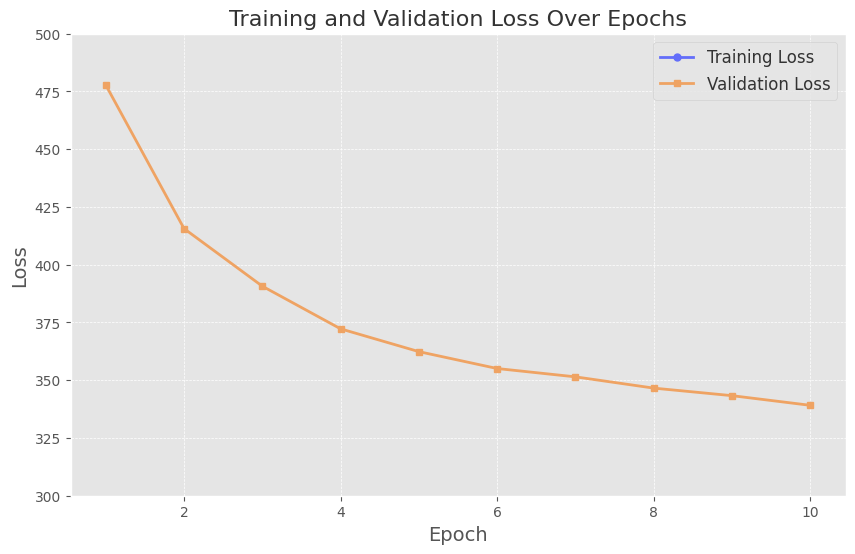

In [72]:
plot_learning_curves(tr_losses, val_losses, (300, 500))

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [55]:
def plot_nums(model, dataset):
    loader = DataLoader(dataset, batch_size=10)
    data, _ = next(iter(loader))
    _, _, reconstruction = model(data.to(device))
    _, axes = plt.subplots(2, 10, figsize=(20, 8))
    for k in range(10):
        axes[0][k].imshow(data[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
        axes[0][k].title.set_text('Input')
        
        axes[1][k].imshow(reconstruction[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
        axes[1][k].title.set_text('Output')
    
        axes[0][k].grid(False)
        axes[1][k].grid(False)
    plt.show()

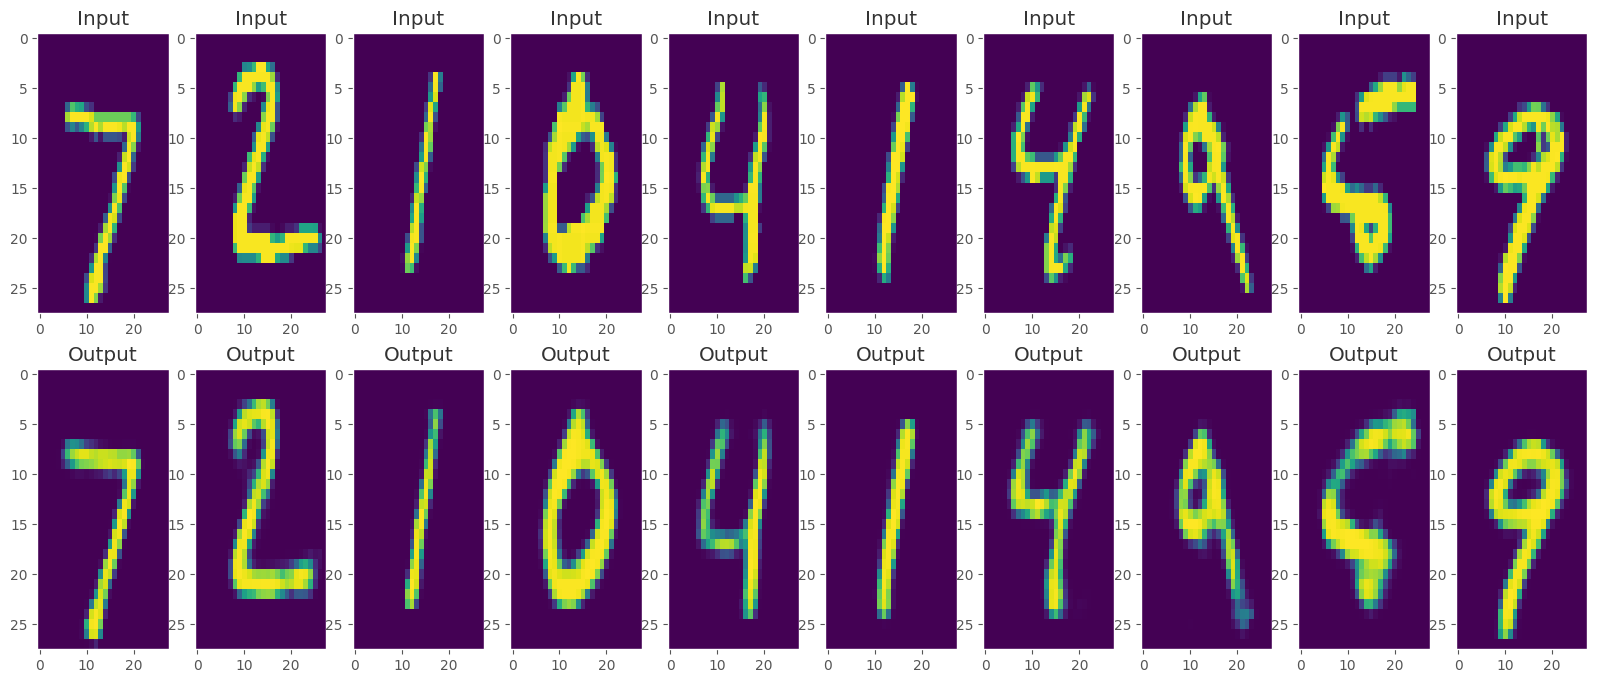

In [73]:
plot_nums(autoencoder, test_dataset)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

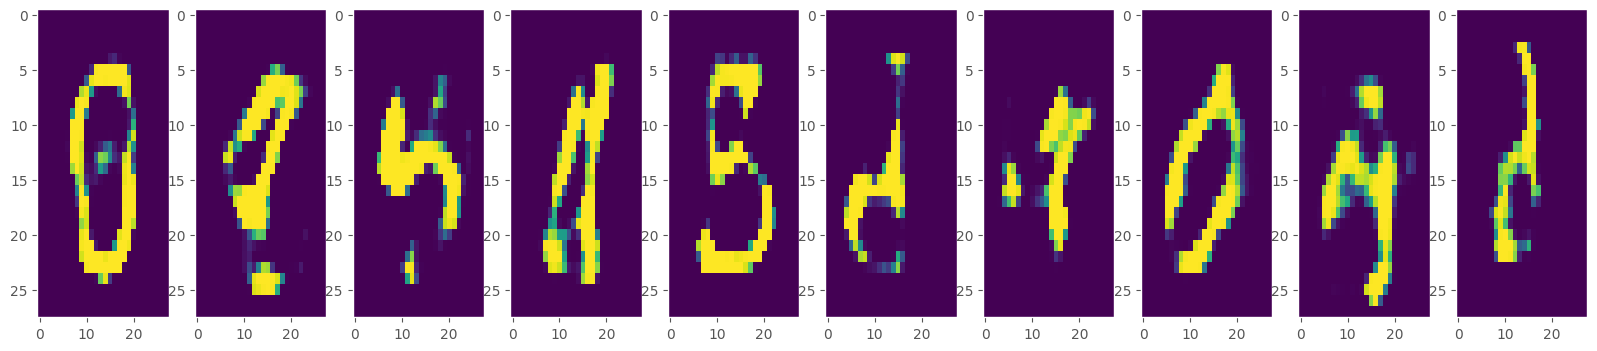

In [92]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 128) for i in range(10)])
output = autoencoder.decode(torch.from_numpy(z).float().to(device))
_, ax = plt.subplots(1, 10, figsize=(20, 4))
for k in range(10):
    ax[k].imshow(output[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
    ax[k].grid(False)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [75]:
temp_loader = DataLoader(test_dataset, batch_size=1) # так удобнее, сделаем лоудер который по 1 батчу выдает 

In [76]:
latent_vectors = [] # создаем список, куда будем грузить значение латентного пространства и цифру которую она репрезентирует
for batch, true in temp_loader:
    batch = batch.to(device)
    latent_vectors.append([autoencoder.get_latent(batch), true])

In [77]:
latent_dict = {} # переводим все в словарь, так удобнее: ключи это уникальные числа, а значения это список латентных векторов которые репрезентируют эти числа
for couple in latent_vectors:
    latent_dict.setdefault(couple[1].item(), [])
    latent_dict[couple[1].item()].append(couple[0].cpu().detach().numpy()) # сразу переводим все в нумпай массив 

In [78]:
all_vectors = [] # далее нужно будет создать список всех вообще лат векторов что бы в конце концов сделать матрицу и загрузить ее в tSNE
latent_sizes = [0] * 10 # тут будут храниться длины срезов каждого числа 
for key in range(10):
    for values in range(len(latent_dict[key])):
        all_vectors.append(latent_dict[key][values][0])
    latent_sizes[key] = len(latent_dict[key])

In [79]:
latent_matrix = np.vstack(all_vectors) # получаем желанную матрицу

In [80]:
latent_sizes # наши длины: первые 980 векторов относятся к числу 0 и тд

[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]

In [81]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

tsne = TSNE(n_components=2, random_state=42)

latent_vectors_2d = tsne.fit_transform(latent_matrix) # получаем двумерное представление векторов

In [138]:
from matplotlib.lines import Line2D
def plot_latent_space(latent_vectors_2d):
    plt.figure(figsize=(10, 8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    labels = [i for i in range(10)]

    plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=np.repeat(colors, latent_sizes), alpha=0.5)

    labels = [str(i) for i in range(10)]  # Метки от 0 до 9

    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, labels)]
    plt.legend(handles=legend_elements, title='Digits')

    plt.title('t-SNE Projection of Latent Vectors')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

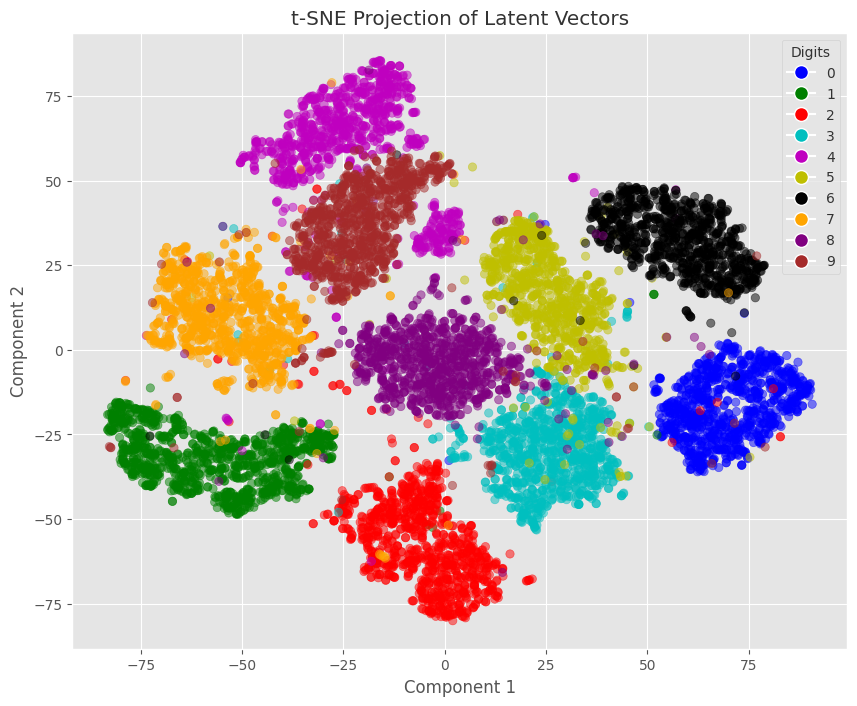

In [82]:
plot_latent_space(latent_vectors_2d)

Что вы думаете о виде латентного представления?

# Выглядит вполне логично, округлые цифры ближе друг к другу, палочковидные цифры с другой стороны (1, 7)

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [133]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=64, class_size=10, image_size=28*28, first_layer_size=512, train=True):
        super().__init__()
        self.latent_dim = latent_dim
        self.class_size = class_size
        self.image_size = image_size
        self.size = first_layer_size
        self.training = train
        
        self.encode_block = nn.Sequential(
            nn.Linear(self.image_size + self.class_size, self.size),
            nn.ReLU(),
            nn.Linear(self.size, int(self.size/2)),
            nn.ReLU(),
            nn.Linear(int(self.size/2), self.latent_dim*2)
        )
        self.flatten = nn.Flatten()
        
        self.decode_block = nn.Sequential(
            nn.Linear(self.latent_dim + self.class_size, int(self.size/2)),
            nn.ReLU(),
            nn.Linear(int(self.size/2), self.size),
            nn.ReLU(),
            nn.Linear(self.size, self.image_size),
            nn.Sigmoid()
        )
    
    def encode(self, x, class_vec):
        x = self.flatten(x)
        x_with_class_vec = torch.cat([x, class_vec], 1)
        mu, logvar = torch.split(self.encode_block(x_with_class_vec), self.latent_dim, dim=-1) 
        return mu, logvar

    def gaussian_sampler(self, mu, logvar):
        if self.training: 
            eps = torch.randn_like(logvar) # `randn_like` as we need the same size
            std = torch.exp(0.5 * logvar) # standard deviation
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_vec):
        x = torch.cat([z, class_vec], 1)
        pre_reconstruction = self.decode_block(x)
        reconstruction = pre_reconstruction.view(-1, 1, 28, 28)
        return reconstruction

    def forward(self, x, class_vec): 
        mu, logvar = self.encode(x, class_vec)
        sample = self.gaussian_sampler(mu, logvar)
        reconstruction = self.decode(sample, class_vec)
        return mu, logvar, reconstruction
    
    def get_latent(self, x, class_vec):
        mu, logvar = self.encode(x, class_vec)
        sample = self.gaussian_sampler(mu, logvar)
        return sample
        

# делаем вспомогательную функцию которая поможет преобразовать информацию о классах из батча в one hot векторы

In [115]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

In [116]:
def train(model, train_loader, val_loader, n_epochs, optimizer, loss_fn):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        print('* Epoch %d/%d' % (epoch+1, n_epochs))
        model.train()
        train_loss = 0
        for batch, classes in train_loader:
            
            batch = batch.to(device)
            class_vec = one_hot(classes, 10) # получаем one_hot_encoded вектор
            
            optimizer.zero_grad()
            mu, logvar, reconstruction = model(batch, class_vec)
            loss = criterion(batch, mu, logvar, reconstruction)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, classes in val_loader:
                batch = batch.to(device)
                class_vec = one_hot(classes, 10) # получаем one_hot_encoded вектор
                mu, logvar, reconstruction = model(batch, class_vec)
                loss = criterion(batch, mu, logvar, reconstruction)
                val_loss += loss.item()
        val_losses.append(val_loss/len(train_loader))
        print(f'Train loss: {round(train_losses[-1], 3)}\nValidation loss: {round(val_losses[-1], 3)}') 
    return train_losses, val_losses


In [134]:
autoencoder = CVAE(latent_dim=128)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

summary(autoencoder,
        input_size=[(32, 1, 28, 28), (32, 10)], # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CVAE (CVAE)                              [32, 1, 28, 28]      [32, 128]            --                   True
├─Flatten (flatten)                      [32, 1, 28, 28]      [32, 784]            --                   --
├─Sequential (encode_block)              [32, 794]            [32, 256]            --                   True
│    └─Linear (0)                        [32, 794]            [32, 512]            407,040              True
│    └─ReLU (1)                          [32, 512]            [32, 512]            --                   --
│    └─Linear (2)                        [32, 512]            [32, 256]            131,328              True
│    └─ReLU (3)                          [32, 256]            [32, 256]            --                   --
│    └─Linear (4)                        [32, 256]            [32, 256]            65,792               True
├─Sequential (decode

In [135]:
tr_losses, val_losses = train(autoencoder.to(device), train_loader, test_loader, 15, optimizer, criterion)

* Epoch 1/15
Train loss: 4781.396
Validation loss: 622.795
* Epoch 2/15
Train loss: 3752.725
Validation loss: 567.484
* Epoch 3/15
Train loss: 3527.548
Validation loss: 544.01
* Epoch 4/15
Train loss: 3431.085
Validation loss: 530.793
* Epoch 5/15
Train loss: 3354.756
Validation loss: 527.708
* Epoch 6/15
Train loss: 3236.42
Validation loss: 512.694
* Epoch 10/15
Train loss: 3220.651
Validation loss: 510.471
* Epoch 11/15
Train loss: 3208.534
Validation loss: 508.93
* Epoch 12/15
Train loss: 3196.581
Validation loss: 507.31
* Epoch 13/15
Train loss: 3186.261
Validation loss: 508.568
* Epoch 14/15
Train loss: 3178.453
Validation loss: 505.624
* Epoch 15/15
Train loss: 3169.444
Validation loss: 502.788


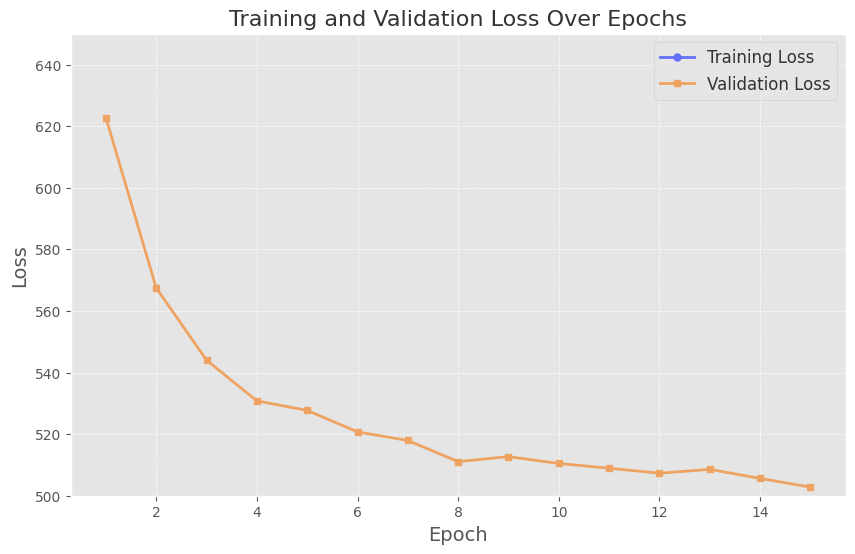

In [137]:
plot_learning_curves(tr_losses, val_losses, (500, 650))

# перепишем plot_nums

In [124]:
def plot_nums(model, dataset):
    loader = DataLoader(dataset, batch_size=10)
    data, classes = next(iter(loader))
    class_vec = one_hot(classes, 10)
    _, _, reconstruction = model(data.to(device), class_vec)
    _, axes = plt.subplots(2, 10, figsize=(20, 8))
    for k in range(10):
        axes[0][k].imshow(data[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
        axes[0][k].title.set_text('Input')
        
        axes[1][k].imshow(reconstruction[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
        axes[1][k].title.set_text('Output')
    
        axes[0][k].grid(False)
        axes[1][k].grid(False)
    plt.show()

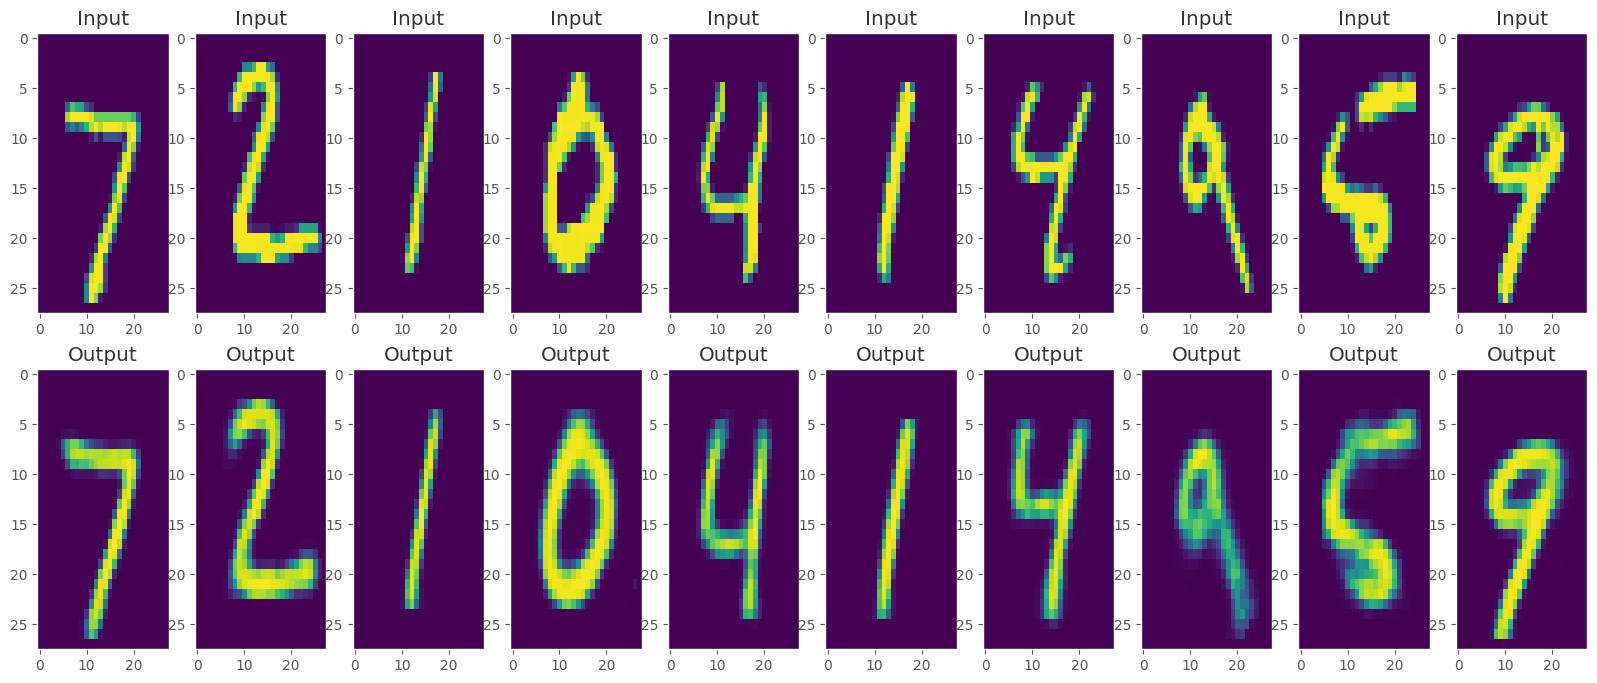

In [125]:
plot_nums(autoencoder, test_dataset)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

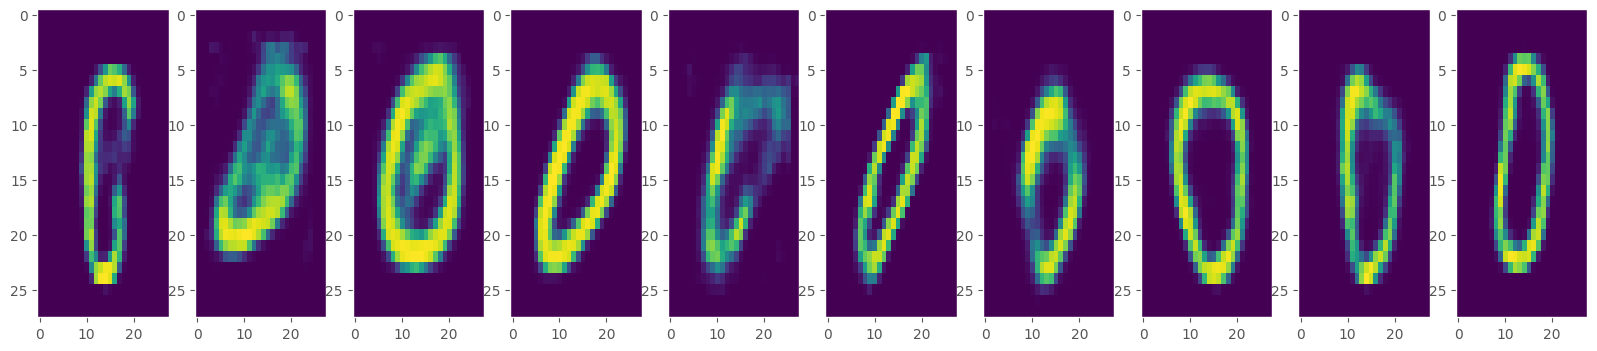

In [131]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 128) for i in range(10)])
class_vec = torch.tensor([0]*10)
class_vec = one_hot(class_vec, 10)
output = autoencoder.decode(torch.from_numpy(z).float().to(device), class_vec)
_, ax = plt.subplots(1, 10, figsize=(20, 4))
for k in range(10):
    ax[k].imshow(output[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
    ax[k].grid(False)

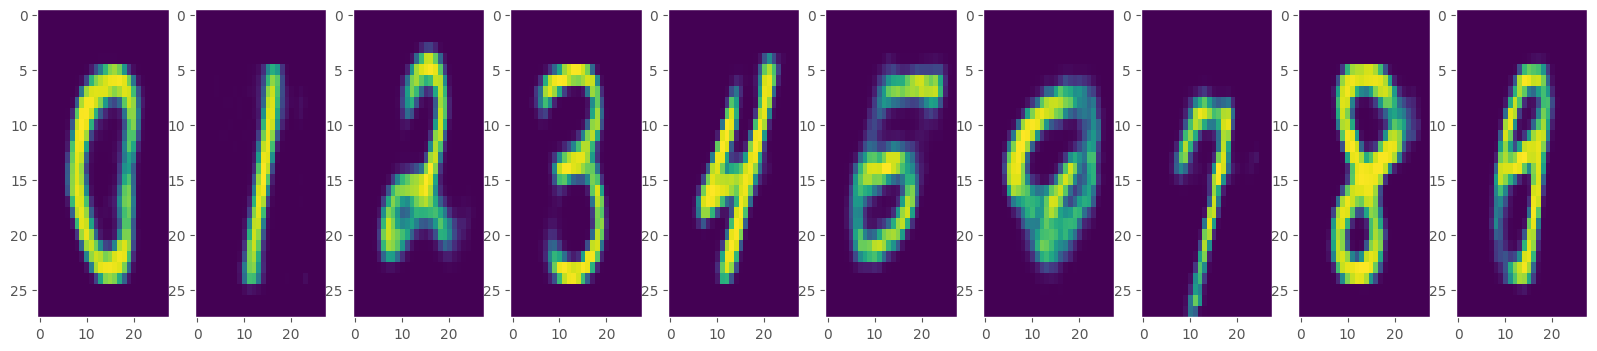

In [132]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 128) for i in range(10)])
class_vec = torch.tensor([0,1,2,3,4,5,6,7,8,9])
class_vec = one_hot(class_vec, 10)
output = autoencoder.decode(torch.from_numpy(z).float().to(device), class_vec)
_, ax = plt.subplots(1, 10, figsize=(20, 4))
for k in range(10):
    ax[k].imshow(output[k].data.cpu().numpy().transpose(1,2,0), aspect='auto')
    ax[k].grid(False)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [139]:
# использую код выше, но с некоторыми модификациями связанными с особенностями работы CVAE:
temp_loader = DataLoader(test_dataset, batch_size=1) 
latent_vectors = [] # создаем список, куда будем грузить значение латентного пространства и цифру которую она репрезентирует
for batch, true in temp_loader:
    batch = batch.to(device)
    class_vec = one_hot(true, 10)
    latent_vectors.append([autoencoder.get_latent(batch, class_vec), true])
latent_dict = {} # переводим все в словарь, так удобнее: ключи это уникальные числа, а значения это список латентных векторов которые репрезентируют эти числа
for couple in latent_vectors:
    latent_dict.setdefault(couple[1].item(), [])
    latent_dict[couple[1].item()].append(couple[0].cpu().detach().numpy()) # сразу переводим все в нумпай массив 
all_vectors = [] # далее нужно будет создать список всех вообще лат векторов что бы в конце концов сделать матрицу и загрузить ее в tSNE
latent_sizes = [0] * 10 # тут будут храниться длины срезов каждого числа 
for key in range(10):
    for values in range(len(latent_dict[key])):
        all_vectors.append(latent_dict[key][values][0])
    latent_sizes[key] = len(latent_dict[key])
latent_matrix = np.vstack(all_vectors) # получаем желанную матрицу

In [140]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

tsne = TSNE(n_components=2, random_state=42)

latent_vectors_2d = tsne.fit_transform(latent_matrix) # получаем двумерное представление векторов

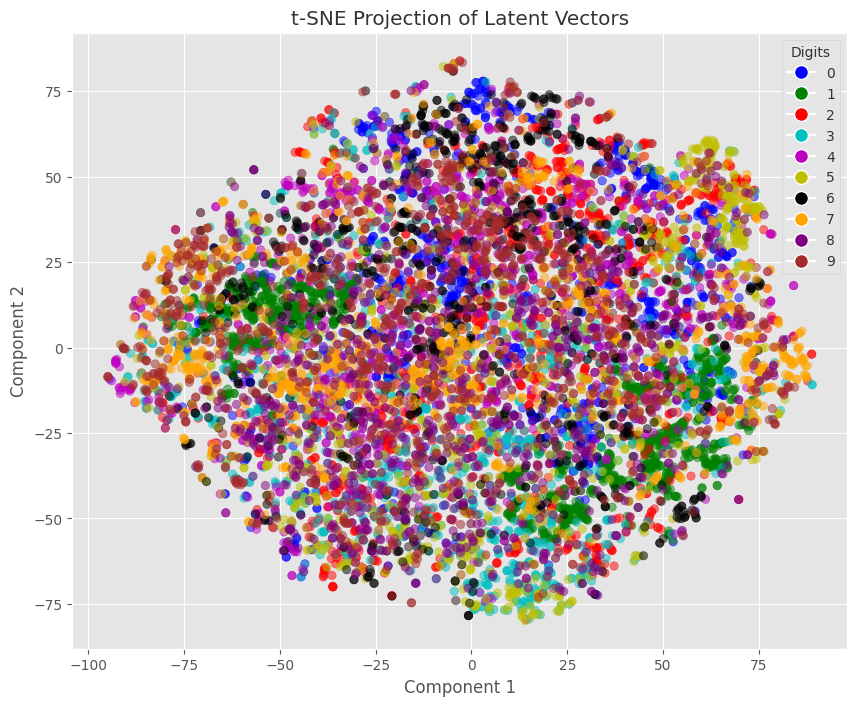

In [141]:
plot_latent_space(latent_vectors_2d)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

ваааау) жесть) не ожидал увидеть такое, но видимо это нормально, необходимость кластеризации отпала, теперь нейросеть восстанавливает картинку исходя не из кластеризации а исходя из вектора который конкатенирован 

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>